In [1]:
from bs4 import BeautifulSoup as bs
import requests
from pprint import pprint
import re
from pprint import pprint

In [2]:
main_link = 'https://hh.ru'

In [3]:
header = {'Accept': '*/*',
          'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0'
}

In [4]:
function_name = 'Data science'

In [5]:
function_name_correct = function_name#.replace(' ', '+')

In [6]:
parameter = {
    'text': function_name_correct,
    'search_period': "30" #1,3,7,30
}

In [7]:
session = requests.session()

In [8]:
def parse(html):
    data = list()
    vacancys_block = html.find('div', {'class':"vacancy-serp vacancy-serp_xs-mode"})
    pattern = re.compile('vacancy-serp-item.*')
    vacancy_block = vacancys_block.findChildren('div', {'class':pattern}, recursive=False)
    for vacancy in vacancy_block:
        dict_ = {}
        
        dict_['name'] = vacancy.find('a', {'class': 'bloko-link HH-LinkModifier'}).text
        dict_['href'] = vacancy.find('a', {'class': 'bloko-link HH-LinkModifier'})['href']
        #dict_['company'] = vacancy.find('a', {'class': 'bloko-link bloko-link_secondary'}).text
        dict_['company'] = vacancy.findAll('div', {'class': 'vacancy-serp-item__meta-info'})[0].text.replace('\xa0', ' ')
        dict_['position'] = vacancy.findAll('div', {'class': 'vacancy-serp-item__meta-info'})[1].text
        dict_['site'] = main_link

        finance = vacancy.find('div', {'class': 'vacancy-serp-item__sidebar'}).text.replace('\xa0', ' ')
        if not finance:
            dict_['finance_min'] = 'no data'
            dict_['finance_max'] = 'no data'
            dict_['valuta'] = 'no data'
        else:        
            pattern_number = re.compile('[0-9]{1,3}\s{1}[0-9]{3}')
            pattren_valuta = re.compile('руб\.|USD|EUR|KZT|грн.')
            pattren_ot = re.compile('от')
            pattren_do = re.compile('до')

            number = re.findall(pattern_number, finance)
            valuta = re.findall(pattren_valuta, finance)
            if valuta:
                valuta = valuta[0]
            

            if len(number) == 2:
                dict_['finance_min'] = number[0]
                dict_['finance_max'] = number[1]
                dict_['valuta'] = valuta
            elif len(number) == 1:
                ot = re.findall(pattren_ot, finance)
                do = re.findall(pattren_do, finance)
                if not do:
                    dict_['finance_min'] = number[0]
                    dict_['finance_max'] = '-'
                    dict_['valuta'] = valuta
                elif not ot:
                    dict_['finance_min'] = '-'
                    dict_['finance_max'] = number[0]
                    dict_['valuta'] = valuta
        
        #print(dict_)
        data.append(dict_) 
    return data

In [9]:
def get_html(link, header):
    response = session.get(link, headers=header)
    # print(response.status_code)
    html = bs(response.text,'lxml')
    return html

In [10]:
def get_next_link(html):
    bufer = html.find('a', {'class':"bloko-button HH-Pager-Controls-Next HH-Pager-Control"})
    if bufer:
        return main_link + bufer['href']
        link = bufer['href']
    else:
        return ''

In [11]:
link = main_link + f'/search/vacancy?search_period=30&salary=&st=searchVacancy&text={function_name_correct}'
#link = 'https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=16'

In [12]:
result = list()
while link:
    print(link)
    html = get_html(link, header)
    result = result +parse(html)
    link = get_next_link(html)

https://hh.ru/search/vacancy?search_period=30&salary=&st=searchVacancy&text=Data science
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=1
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=2
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=3
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=4
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=5
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=6
https://hh.ru/search/vacancy?L_is_autosearch=false&clusters=true&enable_snippets=true&search_period=30&text=Data+science&page=7
https://hh.ru/s

In [13]:
result

[{'name': 'Data Scientist',
  'href': 'https://chelyabinsk.hh.ru/vacancy/35011897?query=Data%20science',
  'company': ' HeadHunter::Analytics/Data Science ',
  'position': 'Москва, Алексеевская',
  'site': 'https://hh.ru',
  'finance_min': '200 000',
  'finance_max': '-',
  'valuta': 'руб.'},
 {'name': 'Аналитик (команда Поиска)',
  'href': 'https://chelyabinsk.hh.ru/vacancy/35121709?query=Data%20science',
  'company': ' HeadHunter::Analytics/Data Science ',
  'position': 'Москва, Алексеевская',
  'site': 'https://hh.ru',
  'finance_min': 'no data',
  'finance_max': 'no data',
  'valuta': 'no data'},
 {'name': 'Python Data Scientist',
  'href': 'https://chelyabinsk.hh.ru/vacancy/35296762?query=Data%20science',
  'company': ' Web Interactive World ',
  'position': 'Москва, Площадь Революции и еще 3 ',
  'site': 'https://hh.ru',
  'finance_min': '150 000',
  'finance_max': '-',
  'valuta': 'руб.'},
 {'name': 'Младший специалист по Data Science, Machine Learning, AI',
  'href': 'https://c

In [14]:
len(result)

868

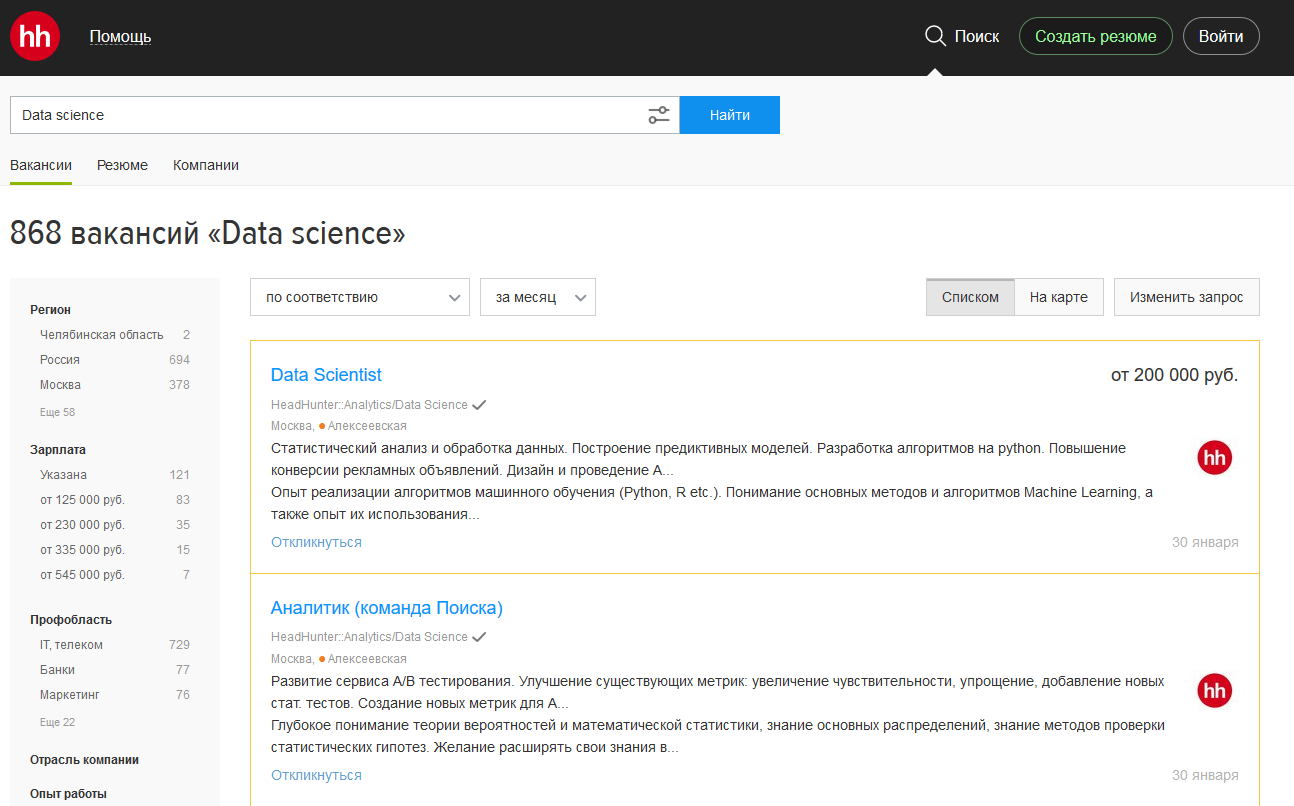

In [16]:
import json
with open("Lesson2_result.json", "w", encoding="utf-8") as file:
    json.dump(result, file)